In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from copy import deepcopy

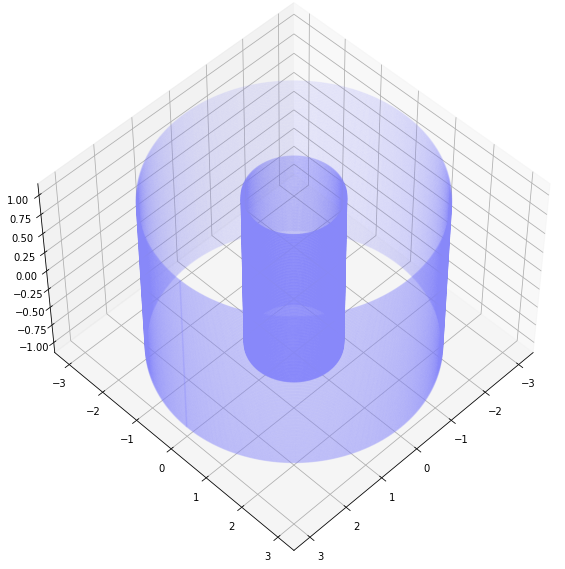

In [2]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
s = 30

h = np.linspace(-1, 1, 100)
fi = np.linspace(0, 2*np.pi, 1000)
r1 = 1
r2 = 3
x1 = [np.cos(a)*r1 for a in fi]
y1 = [np.sin(a)*r1 for a in fi]
x2 = [np.cos(a)*r2 for a in fi]
y2 = [np.sin(a)*r2 for a in fi]
for i in h:
    ax.scatter(x1, y1, i, s=1, color = '#88F3')
    ax.scatter(x2, y2, i, s=1, color = '#88F3')

ax.view_init(elev=50, azim=45)

Это пример кольца, в котором мы и будем считать нашу функцию

Изначально область задана кольцом. Но для удобства мы перейдём к полярным координатам, чтобы было удобнее задавать функцию в узлах прямоугольной сетки:

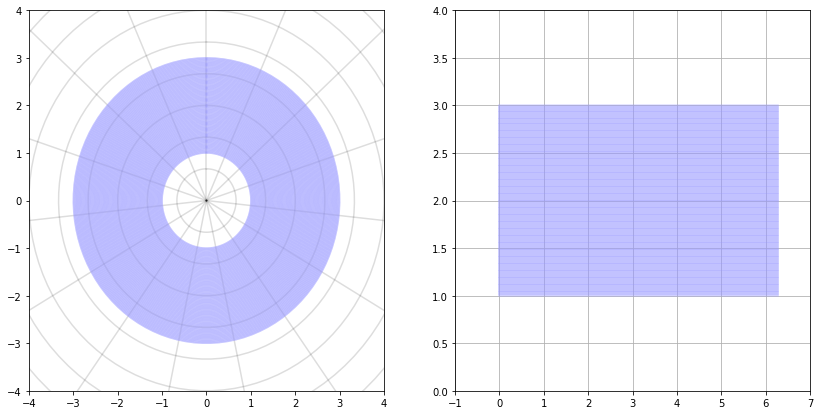

In [3]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
r1 = 1
r2 = 3

mx = 10
t = np.linspace(0, mx, 100)
num = 15
for i in range(num):
    x = np.sin(2*np.pi/num*i)*t
    y = np.cos(2*np.pi/num*i)*t
    plt.plot(x, y, c="#0002")
    
    x = np.sin(np.pi*t*2/mx)*mx/num*i
    y = np.cos(np.pi*t*2/mx)*mx/num*i
    plt.plot(x, y, c="#0002")
    
    
fi = np.linspace(0, 2*np.pi, 100)
clr = "#99F5"
for r in np.linspace(r1, r2, 80):
    x = np.sin(fi)*r
    y = np.cos(fi)*r
    plt.plot(x, y, c=clr)

    x = np.sin(fi)*r
    y = np.cos(fi)*r
    plt.plot(x, y, c=clr)

plt.ylim(-r2-1,r2+1)
plt.xlim(-r2-1,r2+1)

plt.subplot(1, 2, 2)

for t in np.linspace(r1, r2, 300):
    x = np.linspace(0, 2*np.pi, 100)
    y = x*0+t
    plt.plot(x, y, clr)

plt.grid()
plt.ylim(r1-1,r2+1)
plt.xlim(-1,7)
plt.show()

Преобразовали в прямоугольные координаты. Теперь по ним можно смело брать значения точек в узлах сетки и интерполировать.

Зададим функцию
$$
f(x, y) = {x^2}\cdot{y^2} 
$$
таблицей с шагом 
$
\Delta \alpha = \frac{\pi}{12}
$
и
$
\Delta r = 0.4
$
на кольце 
$
1 \leq R \leq 3
$

In [4]:
def f(x, y):
    return x*y**2

a_steps = 24
r_steps = 5

def polar_func(func, alpha, r):
    x = r * np.sin(alpha)
    y = r * np.cos(alpha)
    return(func(x, y))
    

table = np.zeros((a_steps, r_steps, 3))
dotlist = []
i = 0

for alpha in np.linspace(0, 2 * np.pi, a_steps):
    j = 0
    for r in np.linspace(1, 3, r_steps):
        table[i][j] = [alpha, r, polar_func(f, alpha, r)]
        dotlist.append([alpha, r, polar_func(f, alpha, r)])
        j += 1
    i += 1

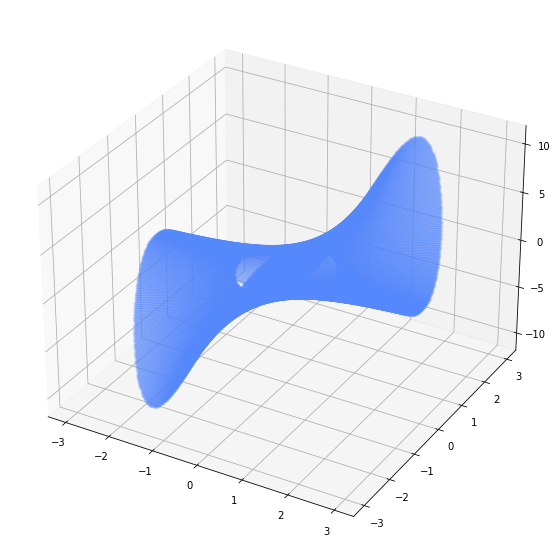

In [5]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

r1 = 1
r2 = 3

x = []
y = []
z = []
for tx in np.linspace(-r2, r2, 270):
    for ty in np.linspace(-r2, r2, 270):
        if (tx**2 + ty**2 < r2**2) and (tx**2 + ty**2 > r1**2):
            x.append(tx)
            y.append(ty)
            z.append(f(tx,ty))
ax.scatter(x, y, z, s=5, c="#58F5")

Теперь выведем нашу таблицу точек:

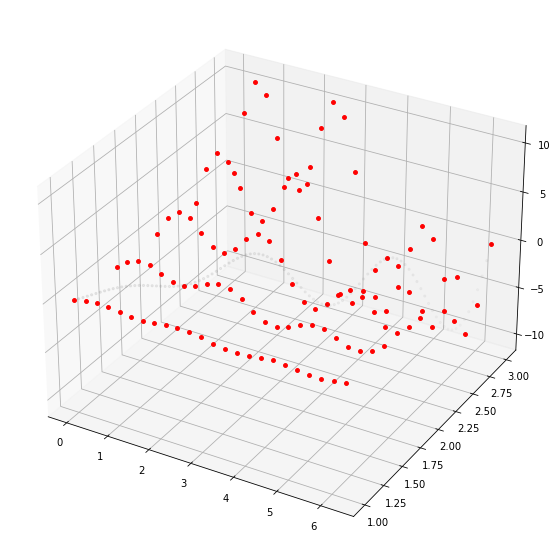

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

alp = np.linspace(0, 2*np.pi, 500)
r = np.linspace(1, 3, 100)
alp, r = np.meshgrid(alp, r)
polarz = polar_func(f, alp, r)

ax.scatter(alp, r, polarz, s=5, color = "#0001")

for el in dotlist:
    ax.scatter(el[0], el[1], el[2], s=15, color = '#F00')
    # print("[{:5.2f}, {:5.2f}, {:5.2f}] - [{:5.2f}, {:5.2f}, {:5.2f}]".format(el[0], el[1], el[2], np.sin(el[0])*el[1], np.cos(el[0])*el[1], el[2]))

В декартовых координатах:

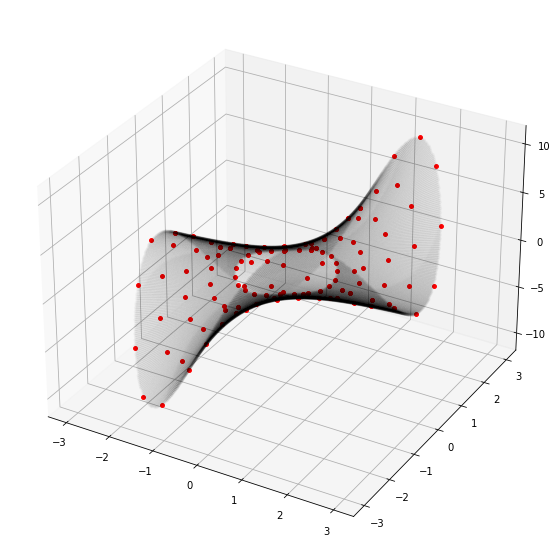

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, s=5, color = "#00000008")

for el in dotlist:
    ax.scatter(np.sin(el[0])*el[1], np.cos(el[0])*el[1], el[2], s=15, color = '#F00')
    # print("[{:5.2f}, {:5.2f}, {:5.2f}] - [{:5.2f}, {:5.2f}, {:5.2f}]".format(el[0], el[1], el[2], np.sin(el[0])*el[1], np.cos(el[0])*el[1], el[2]))

Реализуем **билинейную интерполяцию** на полученных полярных координатах:

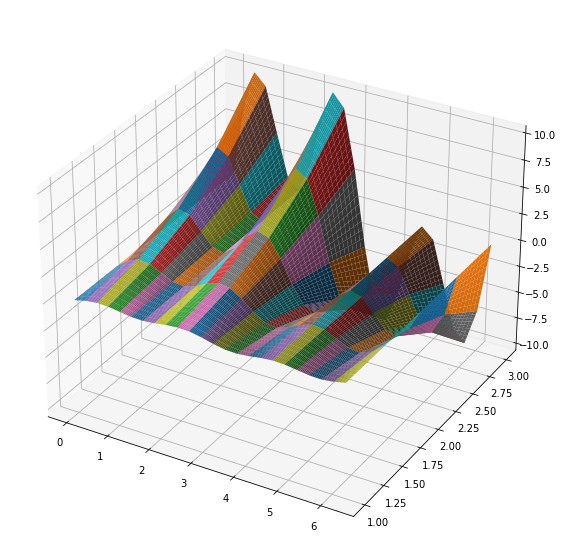

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# ax.scatter(x, y, z, linewidth=0, color = "#0003")

functable = []
for i in range(table.shape[0] - 1):
    tmp = []
    for j in range(table.shape[1] - 1):
        tx0 = table[i][j][0]
        tx1 = table[i+1][j][0]
        ty0 = table[i][j][1]
        ty1 = table[i][j+1][1]
        tz00 = table[i][j][2]
        tz10 = table[i+1][j][2]
        tz01 = table[i][j+1][2]
        tz11 = table[i+1][j+1][2]
        # Формула билинейной интерполяции для прямоугольного участка функции
        def tmpf(x, y, x1 = tx1, x0 = tx0, y0 = ty0, y1 = ty1, z00 = tz00, z10 = tz10, z01 = tz01, z11 = tz11):
            a = 1/(x1-x0)/(y1-y0)
            return a * (z00*(x1-x)*(y1-y) + z10*(x-x0)*(y1-y) + z01*(x1-x)*(y-y0) + z11*(x-x0)*(y-y0))
        ttx = np.linspace(tx0, tx1, 10)
        tty = np.linspace(ty0, ty1, 10)
        ttx, tty = np.meshgrid(ttx, tty)
        ttz = tmpf(ttx, tty)
        ax.plot_surface(ttx, tty, ttz)
        tmp.append(tmpf)
    functable.append(tmp)

В обычных координатах:

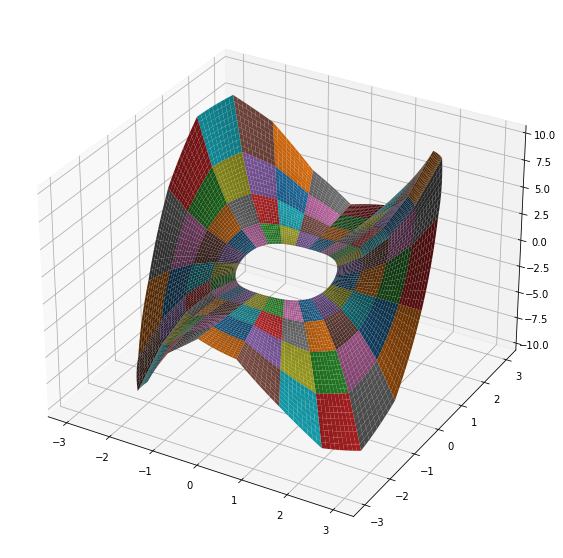

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ti = 0
for i in range(table.shape[0] - 1):
    tj = 0
    for j in range(table.shape[1] - 1):
        tx0 = table[i][j][0]
        tx1 = table[i+1][j][0]
        ty0 = table[i][j][1]
        ty1 = table[i][j+1][1]
        ttx = np.linspace(tx0, tx1, 10)
        tty = np.linspace(ty0, ty1, 10)
        ttx, tty = np.meshgrid(ttx, tty)
        ttz = functable[ti][tj](ttx, tty)
        ax.plot_surface(np.cos(ttx)*tty, np.sin(ttx)*tty, ttz)
        tj+=1
    ti+=1

Получилось интерполировать!

In [10]:
def GetZ(fntable, table, x, y):
    alp = np.arctan(y/x) + np.pi/2 if x!=0 else 0
    r = np.sqrt(x**2 + y**2)
    fnX = fnY = 0
    breaker = False
    for i in range(table.shape[0]):
        if alp < table[i][0][0]:
            for j in range(table.shape[1]):
                if r < table[i-1][j][1]:
                    fnX = i-1
                    fnY = j-1
                    breaker = True
                    break
        if breaker:
            break
    return fntable[fnX][fnY](alp, r)

Сравним несколько случайных точек:

In [11]:
print("     x      |       y      |   f(x,y)   |   GetZ(x,y)  | Погрешность")
print("====================================================================")
ExX = []
ExY = []
ExZ = []
ExF = []
for i in range(20):
    Talpha = random.uniform(0, 2*np.pi) 
    Tr = random.uniform(1, 3) 
    Tx = np.cos(Talpha)*Tr
    Ty = np.sin(Talpha)*Tr
    ExX.append(Tx)
    ExY.append(Ty)
    true = f(Tx, Ty)
    ExZ.append(true)
    mine = GetZ(functable, table, Tx, Ty)
    ExF.append(mine)
    print("{:10.3f}  |  {:10.3f}  |{:10.3f}  |  {:10.3f}  |  {:10.8f}".format(Tx, Ty, true, mine, abs(true-mine)))

     x      |       y      |   f(x,y)   |   GetZ(x,y)  | Погрешность
    -1.940  |       1.011  |    -1.981  |       2.054  |  4.03509560
     1.042  |      -1.721  |     3.086  |       3.095  |  0.00928713
     0.557  |      -1.307  |     0.950  |       0.933  |  0.01728772
     0.257  |       1.171  |     0.352  |       0.374  |  0.02144168
     1.116  |      -0.310  |     0.107  |       0.133  |  0.02618032
     2.300  |      -0.708  |     1.152  |       1.293  |  0.14064951
    -2.544  |       1.588  |    -6.415  |       6.274  |  12.68921804
     0.351  |       2.203  |     1.704  |       1.721  |  0.01784932
     2.697  |      -0.572  |     0.882  |       0.918  |  0.03516636
    -0.231  |      -2.715  |    -1.700  |       1.719  |  3.41924563
     0.092  |      -1.830  |     0.310  |       0.298  |  0.01148431
     1.823  |      -0.064  |     0.008  |       0.116  |  0.10872044
    -0.025  |       1.414  |    -0.050  |       0.048  |  0.09873013
    -1.580  |      -0.054  |    -

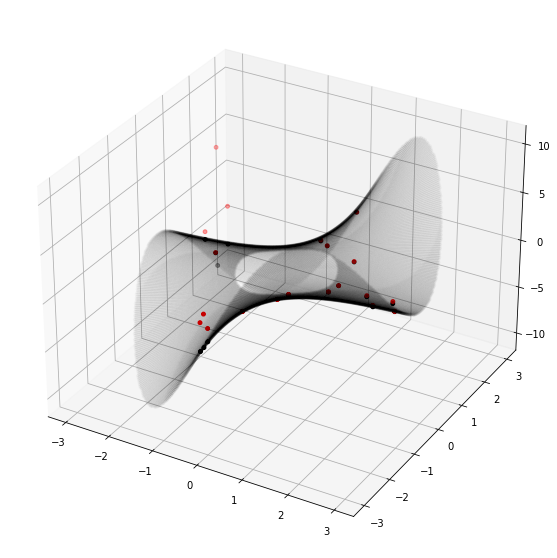

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

x = []
y = []
z = []
Iz = []
for tx in np.linspace(-r2, r2, 270):
    for ty in np.linspace(-r2, r2, 270):
        if (tx**2 + ty**2 < r2**2) and (tx**2 + ty**2 > r1**2):
            x.append(tx)
            y.append(ty)
            z.append(f(tx,ty))
            Iz.append(GetZ(functable, table, tx, ty))
ax.scatter(x, y, z, s=5, c="#00000008")
# ax.scatter(x, y, Iz, s=5, c="#58F5")

ax.scatter(ExX, ExY, ExZ, s=15, c="#000")
ax.scatter(ExX, ExY, ExF, s=15, c="#F00")
